**feature map:** A mapping of input data to the quantum Hilbert space

**kernel:** A function of two datapoints that measures the similarity between them

When considering finite data, a kernel function can be represented by a matrix:

$$ K_{ij} = k(\vec{x}_{i}, \vec{x}_{j}) $$

Let's demonstrate the concept of mapping a dataset to a higher dimensional feature space, with the [circle datset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), which contains a large circle containing a smaller circle in two dimensions

In [19]:
# qiskit
from qiskit import opflow, BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.kernels import QuantumKernel
# otros
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pylab as pl
# sklearn
from sklearn.datasets import make_circles
from sklearn.svm import SVC

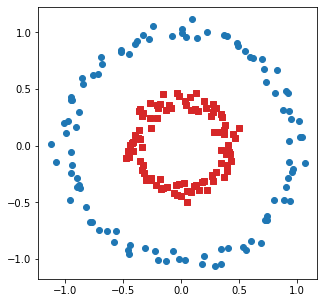

In [5]:
# create circles datset
X,Y = make_circles(n_samples=200, noise=0.05, factor=0.4)

# Separate smaller and larger circles
A = X[np.where(Y==0)]
B = X[np.where(Y==1)]

# Plot in 2D
plt.figure(figsize=(5,5))
plt.scatter(A[:,0],A[:,1], marker='o')
plt.scatter(B[:,0],B[:,1], marker='s', c='C3')
plt.show()

Looking at the dataset, it's clear there is structure to it, but the two circles are not linearly separable in two dimensions. Let's transform the data into three dimensions, where $z = x^{2} + y^{2}$

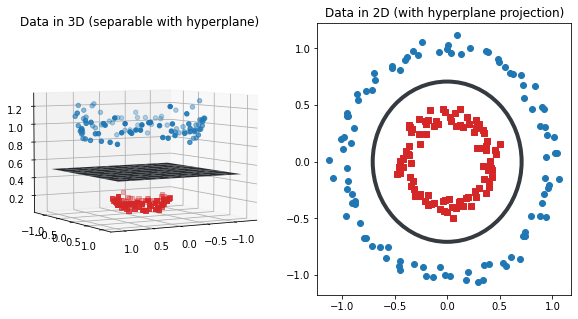

In [6]:
def transform_function(x, y):
    """ Implements f(x,y) = [x, y, z = x^2 + y^2] """
    return np.array([x, y, x**2.0 + y**2.0])

# Transform
A1 = np.array([transform_function(x, y) for
               x, y in zip(np.ravel(A[:,0]), np.ravel(A[:,1]))])
B1 = np.array([transform_function(x, y)
               for x, y in zip(np.ravel(B[:,0]), np.ravel(B[:,1]))])

# Plot in 3D
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Data in 3D (separable with hyperplane)")
ax.scatter(A1[:,0], A1[:,1], A1[:,2], marker='o')
ax.scatter(B1[:,0], B1[:,1], B1[:,2], marker='s', c='C3')  # make red
ax.view_init(5, 60)
x = np.arange(-1.25, 1.25, 0.25)
y = np.arange(-1.25, 1.25, 0.26)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z[:,:] = 0.5
ax.plot_surface(X, Y, Z, color='#343A3F')

# Project data to 2D
ax2d = fig.add_subplot(122)
ax2d.set_title("Data in 2D (with hyperplane projection)")
ax2d.scatter(A1[:,0], A1[:,1], marker='o')
ax2d.scatter(B1[:,0], B1[:,1], marker='s',
            c='C3')  # make red
ax2d.add_patch(pl.Circle((0,0), radius=np.sqrt(0.5),
               fill=False, linestyle='solid', linewidth=4.0,
               color='#343A3F'))
plt.show()

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
## <span style="color:blue"> Quantum Feature maps </span>

In quantum machine learning, a quantum feature map, $\phi (\vec{x})$, maps a classical feature vector, $\vec{x}$, to a quantum Hilbert space, $\ket{\phi (\vec{x})} \bra{\phi (\vec{x})}$. This takes $\vec{x} \rightarrow \bra{\phi (\vec{x})}$ using a unitary transformation $U_{\phi} (\vec{x})$ which is tipically a parametrized quantum circuit.

On Qiskit, there is a quantum feature map ([PauliFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html)) that is conjectured to be hard simulate classically, and can be implemented as short-depth circuits on near-term quantum devices

$$ U_{\Phi (\vec{x})} = \prod_{d} U_{\Phi (\vec{x})}H^{\otimes n} = exp\left( i \sum_{S \subseteq|n|} \phi_{S}(\vec{x}) \prod_{k \in S} P_{i} \right) $$

which contains layers of Hadamard gates interleaved with entangling blocks.

$U_{\Phi (\vec{x})}$, encoding the classical data as shown for $d=2$

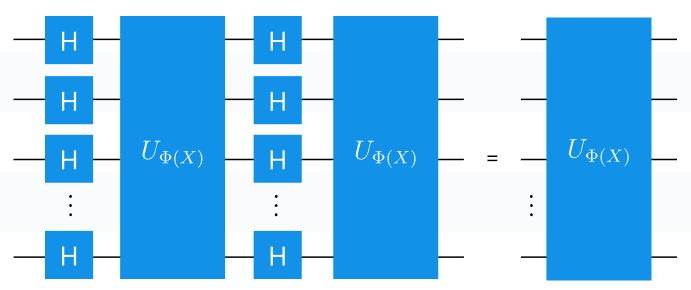

When the entangling blocks $U_{\Phi (\vec{x})} : P_{i} \in \{I,X,Y,Z \}$ dneotes the Pauli matrices, the index $S$ descrives connectivity between different qubits or data points: $S \in \begin{pmatrix} n\\ p \end{pmatrix} combinations, k = 1,...,n$ and by default the data mapping function is

\begin{equation}
\phi_{S}: \vec{x} \rightarrow
\begin{matrix}
x_{i} & \text{if } S=\{i\} \\
(\pi - x_{i}) (\pi - x_{i}) & \text{if } S=\{i, j\} 
\end{matrix}
\end{equation}

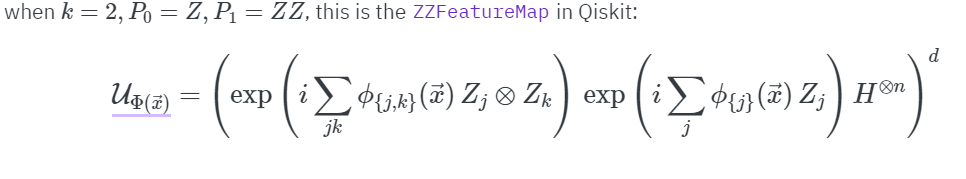

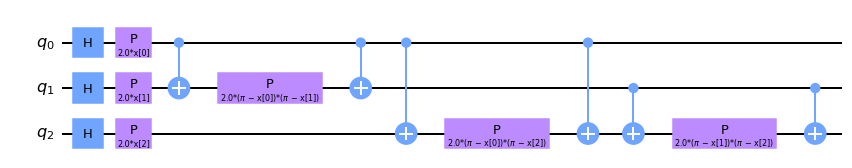

In [8]:
# 3 features, depth 1
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.decompose().draw(output='mpl')

Let's have a look at the adhoc dataset in Qiskit, which is a two class dataset sampled from the ZZFeatureMap used in Reference 1, creating 20 training data points and 5 testing data points of 2 features from each class:

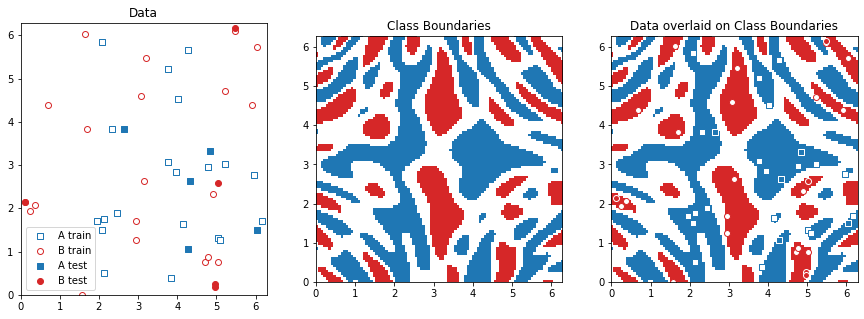

In [11]:
algorithm_globals.random_seed = 12345

train_data, train_labels, test_data, test_labels, sample_total = (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3,
                include_sample_total=True, one_hot=False))

# Plot data and class boundaries
fig = plt.figure(figsize=(15, 5))
axdata = fig.add_subplot(131)
axdata.set_title("Data")
axdata.set_ylim(0, 2 * np.pi)
axdata.set_xlim(0, 2 * np.pi)
plt.scatter(train_data[np.where(train_labels[:] == 0), 0],
            train_data[np.where(train_labels[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='C0',
            label="A train")
plt.scatter(train_data[np.where(train_labels[:] == 1), 0],
            train_data[np.where(train_labels[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='C3',
            label="B train")
plt.scatter(test_data[np.where(test_labels[:] == 0), 0],
            test_data[np.where(test_labels[:] == 0), 1],
            marker='s', facecolors='C0', label="A test")
plt.scatter(test_data[np.where(test_labels[:] == 1), 0],
            test_data[np.where(test_labels[:] == 1), 1],
            marker='o', facecolors='C3', label="B test")
plt.legend()

cmap = ListedColormap(["C3","w","C0"])
axmap = fig.add_subplot(132)
axmap.set_title("Class Boundaries")
axmap.set_ylim(0, 2 * np.pi)
axmap.set_xlim(0, 2 * np.pi)
axmap.imshow(np.asmatrix(sample_total).T,
             interpolation='nearest',
             origin='lower', cmap=cmap,
             extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth = fig.add_subplot(133)
axboth.set_title("Data overlaid on Class Boundaries")
axboth.set_ylim(0, 2 * np.pi)
axboth.set_xlim(0, 2 * np.pi)
axboth.imshow(np.asmatrix(sample_total).T, interpolation='nearest',
              origin='lower', cmap=cmap,
              extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth.scatter(train_data[np.where(train_labels[:] == 0), 0],
               train_data[np.where(train_labels[:] == 0), 1],
               marker='s', facecolors='w', edgecolors='C0', label="A")
axboth.scatter(train_data[np.where(train_labels[:] == 1), 0],
               train_data[np.where(train_labels[:] == 1), 1],
               marker='o', facecolors='w', edgecolors='C3', label="B")
axboth.scatter(test_data[np.where(test_labels[:] == 0), 0],
               test_data[np.where(test_labels[:] == 0), 1],
               marker='s', facecolors='C0', edgecolors='w',
               label="A test")
axboth.scatter(test_data[np.where(test_labels[:] == 1), 0],
               test_data[np.where(test_labels[:] == 1), 1],
               marker='o', facecolors='C3', edgecolors='w',
               label="B test")
plt.show()

On the left above, we see 25 two-dimensional data points from each class in adhoc dataset, noting that there is no obvious pattern as to which data point belongs to which class. In the middle above, is the two-dimensional projection of the sixteen-dimensional (fifteen in reality) feature space described by the ZZFeatureMap used to create the dataset, noting how complicated the class boundaries are in two dimensions. On the right, we see the data points overlaid on the class boundaries

## <span style="color:blue"> Quantum kernels </span>

A quantum map $\phi (\vec{x})$ gives raise to a quantum kernel $K(\vec{x}_{i}, \vec{x}_{j}) = \phi (\vec{x})^{\dagger} \phi (\vec{x})$, which we can think as a measure of similarity. *k* is large when the points are close.

When considering finite data, we can represent the kernel as a matrix

\begin{equation}
K_{ij} = \left| \braket{ \phi (\vec{x}) }{ \phi (\vec{x}) } \right|^{2} = \left| \bra{0^{\otimes n}} U_{\phi (\vec{x})}^{\dagger} U_{\phi (\vec{x})} \ket{0^{\otimes n}} \right|^{2}
\end{equation}

assuming the feature map is a parameterized quantum circuit, which can be described as a unitary transformation *U* on *n* qubits. This provides us with an estimate of the quantum kernel matrix, which we can then use in a kernel machine learning algorithm, such as support vector classification.

Let's analytically calculate and plot the kernel matrix for the training data points in the adhoc dataset we created earlier. For the feature map, we will using the ZZFeatureMap for 2 features with 2 repetitions. Note that the calculate_kernel function here is a simpler version of the evaluate function in the Qiskit QuantumKernel class

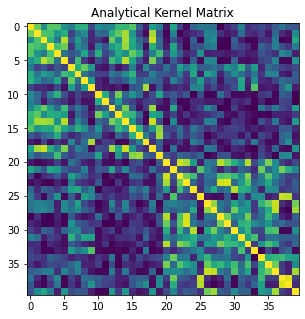

In [13]:
def calculate_kernel(feature_map, x_data, y_data=None):
    """
        Calculates  kernel matrix from provided feature map and
        dataset(s), x & (y). If y isn't given, self inner product
        of x is calculated.
        No error checking is performed, feature map and datasets
        assumed to have the same dimension
    """
    if y_data is None:
        y_data = x_data
    # Use Operator Flow to create a list of feature map circuits,
    # parameterized by each data point
    x_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(x_data).tolist()))
        )
    y_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(y_data).tolist()))
        )
    # Compute the square of the conjugate inner product of the feature
    # map circuits: the kernel matrix
    kernel = np.abs(
        (~y_circuits.to_matrix_op() @ x_circuits.to_matrix_op()).eval()
    )**2
    return kernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
kernel = calculate_kernel(adhoc_feature_map, train_data)
plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(kernel),interpolation='nearest', origin='upper')
plt.title("Analytical Kernel Matrix")
plt.show()

A few things

1.- Each row / column represents the transition amplitude of a single data point, with all other data points in the dataset
2.- The transition amplitude of a data point with itself is 1, so the matrix has a unit diagonal
3.- The matrix is symmetric, $ x \rightarrow y = y \rightarrow x $ 

## <span style="color:blue"> Quantum support vector classification </span>

As mentioned at the start of this section, many machine learning algorithms use kernel functions to map their input dataset to a higher dimensional feature space. The well known support vector machine classification algorithm is one of these. For more information about the support vector classification algorithm, see the [scikit-learn User Guide](https://scikit-learn.org/stable/modules/svm.html).

A support vector machine constructs a hyperplane in feature space, which can then be used for classification, regression or other tasks. For classification, the hyperplane ideally has the largest distance to the nearest training data points for any class. The figure below shows the decision function for a linearly separable problem, with three samples on the class boundaries, called “support vectors”:

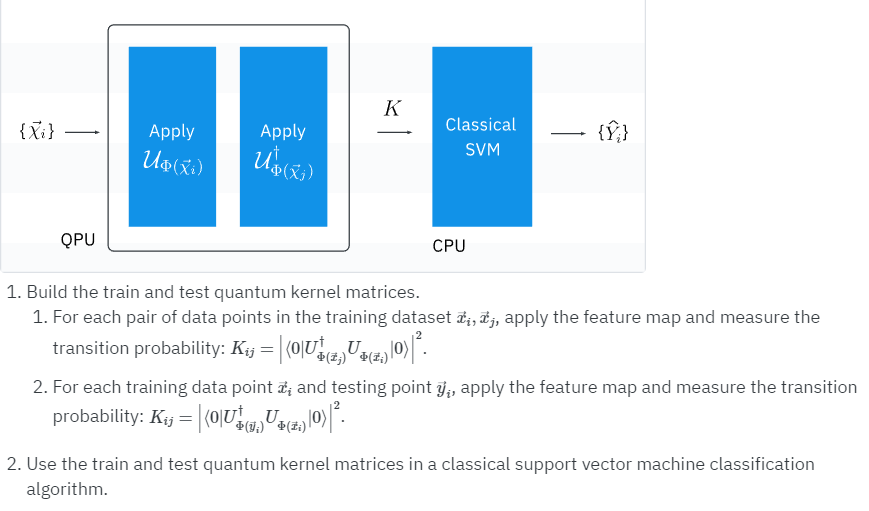

Let's execute the quantum kernel support vector classification algorithm on the adhoc dataset we generated earlier. Recall that this dataset was created from the ZZFeatureMap with depth = 2 and dimension = 2, and consisted of 2 classes, with 20 training and 5 testing data points from each class.

First, let's calculate the training and testing quantum kernel matrices using the calculate_kernel function we wrote earlier:

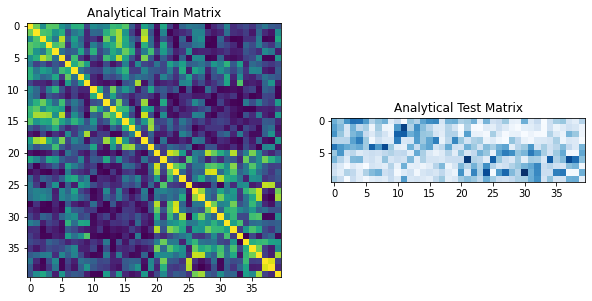

In [14]:
train_kernel = calculate_kernel(adhoc_feature_map, train_data)
test_kernel = calculate_kernel(adhoc_feature_map, train_data, test_data)
# plot analytical matrices
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.asmatrix(train_kernel), interpolation='nearest',
              origin='upper')
axs[0].set_title("Analytical Train Matrix")
axs[1].imshow(np.asmatrix(test_kernel), interpolation='nearest',
              origin='upper', cmap='Blues')
axs[1].set_title("Analytical Test Matrix")
plt.show()

Now let's use them in the scikit-learn svc algorithm:

In [16]:
# train scikit-learn svm model
model = SVC(kernel='precomputed')
model.fit(train_kernel, train_labels)
print("Number of support vectors for each class:",model.n_support_)
print("Indices of support vectors:", model.support_)

Number of support vectors for each class: [ 9 10]
Indices of support vectors: [ 3  6  7  8  9 11 12 17 19 21 22 24 25 26 27 31 33 38 39]


Remember that a support vector machine constructs a hyperplane in feature space, and for classification, the hyperplane ideally has the largest distance to the nearest training data points for any class. The nearest training data points to the separating hyperplane in each class are called “support vectors”. So here the scikit-learn svc algorithm has identified 9 support vectors for the first class, and 10 support vectors for the second class, out of the training dataset, which had 20 data points from each class

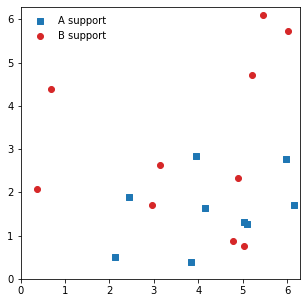

In [17]:
# Plot support vectors
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.scatter(train_data[model.support_[0:model.n_support_[0] ], 0],
            train_data[model.support_[0:model.n_support_[0] ], 1],
            marker='s', label="A support")
plt.scatter(train_data[model.support_[model.n_support_[0]:], 0],
            train_data[model.support_[model.n_support_[0]:], 1],
            marker='o', c='C3', label="B support")
plt.legend(loc='upper left', frameon=False)
plt.show()

In [18]:
# test svm model
model.score(test_kernel, test_labels)

1.0

#### <span style="color:green"> Qiskit implementation </span>

In [20]:
# Create the quantum feature map
adhoc_feature_map = ZZFeatureMap(feature_dimension=2,
                                 reps=2,
                                 entanglement='linear')
# Create the quantum kernel
adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map,
                             quantum_instance=BasicAer.get_backend(
                                             'statevector_simulator'))

# Set the SVC algorithm to use our custom kernel
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(train_data, train_labels)
adhoc_svc.score(test_data, test_labels)

1.0

## <span style="color:blue"> Quantum kernel alignment </span>

All the feature map (data encoding) circuits we have seen so far haven't contained any trainable parameters - all the parameters in the circuits are defined by the data being encoded. Quantum feature maps can have variational parameters, that can be optimized using a technique called kernel alignment, as discussed in References 3 and 4, and described in the [Quantum Kernel Alignment with Qiskit Runtime Tutorial](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/index.html). This is analogous to kernel alignment in [classical machine learning](https://link.springer.com/article/10.1007%2Fs10462-012-9369-4)